In [1]:
import tweepy as tw
import json
import os
import requests
import sys
import warnings
import time
import random
import logging
warnings.filterwarnings("ignore")

In [2]:
# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

In [3]:
# returns python object representation of JSON in response
def get_response(symbol, older_than, retries=5):
    url = 'https://api.stocktwits.com/api/2/streams/symbol/%s.json?max=%d' % (symbol, older_than-1)
    for _ in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return json.loads(response.content)
        elif response.status_code == 429:
            print(response.content)
            return None
        time.sleep(1.0)
    # couldn't get response
    return None

In [4]:
# extends the current dataset for a given symbol with more twits
def get_older_tweets(symbol, num_queries):    
    path = 'Data/StockTwits/%s.json' % symbol
    if os.path.exists(path):
        # extending an existing json file
        with open(path, 'r') as f:
            data = json.load(f)
            if len(data) > 0:
                older_than = data[-1]['id']
            else:
                older_than = 1000000000000
    else:
        # creating a new json file
        data = []
        older_than = 1000000000000  # any huge number
    
    for i in range(num_queries):
        content = get_response(symbol, older_than)
        if content == None:
            print('Error, an API query timed out')
            break
        data.extend(content['messages'])
        older_than = data[-1]['id']
        sys.stdout.write('\rSuccessfully made query %d' % (i+1))
        sys.stdout.flush()
        # sleep to make sure we don't get throttled
        time.sleep(0.5)
    
    full_data = {}
    full_data["data"]=data
        
    # write the new data to the JSON file
    with open(path, 'w') as f:
        json.dump(full_data, f)
    print
    print('...Done')

In [ ]:
symbols = ['BTC.X', 'SOL.X', 'AXS.X', 'SAND.X','TRX.X', 'SLP.X', 'USDT.X','Metaverse','Meta','ETH.X','BNB.X', 'LUNA.X','MANA.X', 'ENJ.X', 'RACA.X', 'AVAX.X', 'DOT.X','DOGE.X', 'MATIC.X', 'SHIB.X']
tweets_per_symbol = 10000
for symbol in symbols:
    path = 'Data/StockTwits/%s.json' % symbol
    if os.path.exists(path):
        with open(path, 'r') as f:
            num_tweets = len(json.load(f))
    else:
        num_tweets = 0
    num_queries = int((tweets_per_symbol - num_tweets - 1)/30 + 1)
    
    if num_queries > 0:
        print('Getting tweets for symbol %s' % symbol)
        get_older_tweets(symbol, num_queries)

**Metrics**

As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [8]:
import re
from os import walk
# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))
from datetime import datetime as dt
from datetime import timedelta as timedelta
from tqdm.notebook import tqdm
from collections import Counter

# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eikde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eikde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eikde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt


In [10]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [11]:
def load_tweet(filename, dirpath):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    fullpath = dirpath + "/" + filename
    print("path: {0}".format(fullpath))
    with open(fullpath, 'r') as f:
        twits = json.load(f)

    #print(twits['data']['body'][:10])
    print("The number of twits is: ", len(twits['data']))
    timestamp = [twit['created_at'] for twit in twits['data']]
    messages = [twit['body'] for twit in twits['data']]

    # Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in the network
    sentiments = []
    for item in twits['data']:
        entities = item.get('entities')
        if entities['sentiment'] == None:
            sentiments.append(1)
        else:
            if entities['sentiment']['basic'] == 'Bullish':
                sentiments.append(2)
            elif entities['sentiment']['basic'] == 'Bearish':
                sentiments.append(0)
            else:
                sentiments.append(1)
        
      #sentiments.append(entities)

    #print('Sample Messages: \n', messages[:10])
    return timestamp, messages, sentiments

In [12]:
def format_date(date):
    # Record the date of the earliest post in our dataset for stock price extraction
    start_date = min(date)[:10]
    # Convert time to Eastern Time (NY time)
    timestamp = [(dt.strptime(t, "%Y-%m-%dT%H:%M:%SZ")-timedelta(hours=4, minutes=0)) for t in date]
    twits_time_ET = [t.time() for t in timestamp]
    twits_date = [t.date() for t in timestamp]
    
    return timestamp, twits_time_ET, twits_date

In [13]:
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Remove stop words
    word_tokens = word_tokenize(text)
    filtered = []
    filtered = [w for w in word_tokens if not w in stop]
    filtered = TreebankWordDetokenizer().detokenize(filtered)
    
    return filtered

In [14]:
# Load data
path = "Data/StockTwits"

messages = []
sentiments = []
timestamps = []
twits_time_ETs = []
twits_dates = []

all_crypto_label = pd.DataFrame()

for (dirpath, dirnames, filenames) in walk(path):
    for filename in filenames:
        if filename.lower().endswith('.json'):
            timestamp, message, sentiment = load_tweet(str(filename), str(dirpath))
            timestamp, twits_time_ET, twits_date = format_date(timestamp)

            timestamps.append(timestamp)
            messages.append(message)
            sentiments.append(sentiment)
            twits_time_ETs.append(twits_time_ET)
            twits_dates.append(twits_date)

            preprocessed = [preprocess(msg) for msg in tqdm(message)]

            tmp_dict = {'date': twits_date, 'time_ET': twits_time_ET, 'org message': message, 'sentence': preprocessed, 'label': sentiment }
            data = pd.DataFrame(tmp_dict)
            all_crypto_label = all_crypto_label.append(data)

all_crypto_label.to_csv(r"Data/StockTwits.csv", sep="\t")      

path: Data/StockTwits/AVAX.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/AXS.X.json
The number of twits is:  3567


  0%|          | 0/3567 [00:00<?, ?it/s]

path: Data/StockTwits/BNB.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/BTC.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/DOGE.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/DOT.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/ENJ.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/ETH.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/LUNA.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/MANA.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/MATIC.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/Meta.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/Metaverse.json
The number of twits is:  57


  0%|          | 0/57 [00:00<?, ?it/s]

path: Data/StockTwits/RACA.X.json
The number of twits is:  313


  0%|          | 0/313 [00:00<?, ?it/s]

path: Data/StockTwits/SAND.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/SHIB.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/SLP.X.json
The number of twits is:  4035


  0%|          | 0/4035 [00:00<?, ?it/s]

path: Data/StockTwits/SOL.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/TRX.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

path: Data/StockTwits/USDT.X.json
The number of twits is:  10020


  0%|          | 0/10020 [00:00<?, ?it/s]

In [15]:
# Check
test_message = 'RT @google Our annual looked at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG'
print(preprocess(test_message))


rt annual looked year google blogging beyond


# Data Exploration

In [16]:
def explore_frequent_words(messages): 
    preprocesseds = []
    # Process for all messages
    for message in messages:
        preprocessed = [preprocess(msg) for msg in tqdm(message)]
        preprocesseds.append(preprocessed)

        all_words = [word for message in preprocessed for word in message.split()]
        print('The number of all words: ', len(all_words))

        counts = Counter(all_words)
        print('The number of unique words: ', len(counts))

        bow = sorted(counts, key=counts.get, reverse=True)
        print('Top 40 frequent words: ', bow[:40])

        text = " ".join(all_words)

        # Generate a word cloud image
        wordcloud = WordCloud(stopwords=None, max_font_size=50, max_words=100, background_color="white").generate(text)
        plt.figure(figsize=(15,7))
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  86773
The number of unique words:  7997
Top 40 frequent words:  ['x', 'avax', 'new', 'crypto', 'avalanche', 'article', 'chan', 'price', 'buy', 'like', 'last', 'get', 'back', 'go', 'next', 'going', 'time', 'market', 'com', 'see', 'one', 'via', 'st', 'topstonks', 'good', 'top', 'long', 'dip', 'still', 'days', 'buying', 'let', 'hours', 'bought', 'bitcoin', 'money', 'coin', 'today', 'way', 'run']


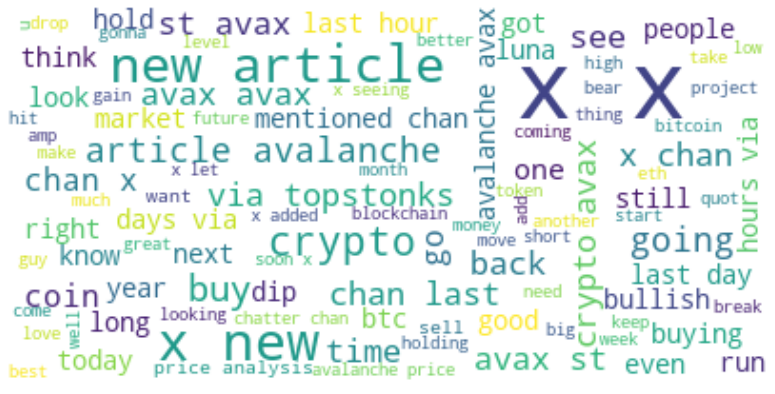

  0%|          | 0/3567 [00:00<?, ?it/s]

The number of all words:  41492
The number of unique words:  5026
Top 40 frequent words:  ['x', 'axs', 'axie', 'new', 'crypto', 'infinity', 'article', 'twitch', 'game', 'metaverse', 'last', 'com', 'play', 'like', 'st', 'via', 'nft', 'topstonks', 'next', 'buy', 'price', 'days', 'one', 'get', 'earn', 'time', 'mentioned', 'market', 'gaming', 'coin', 'top', 'see', 'hours', 'check', 'cap', 'going', 'look', 'still', 'go', 'p']


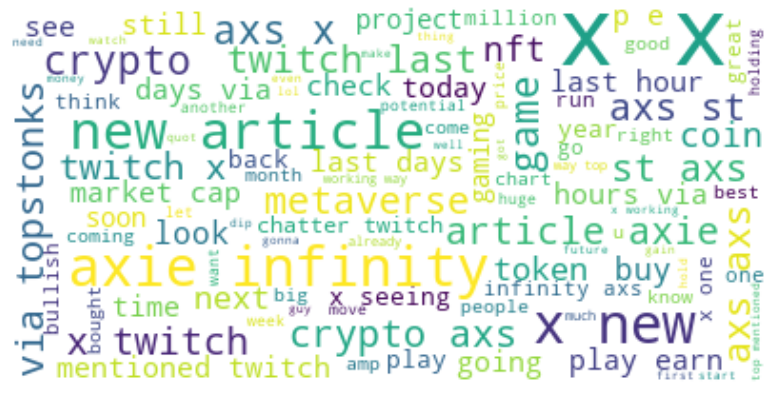

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  133451
The number of unique words:  9756
Top 40 frequent words:  ['x', 'bnb', 'crypto', 'binance', 'new', 'com', 'last', 'coin', 'st', 'via', 'twitch', 'exchange', 'topstonks', 'chan', 'market', 'article', 'days', 'price', 'bitcoin', 'buy', 'get', 'token', 'one', 'hours', 'mentioned', 'chain', 'like', 'trading', 'next', 'amp', 'going', 'project', 'top', 'check', 'way', 'time', 'money', 'seeing', 'us', 'coming']


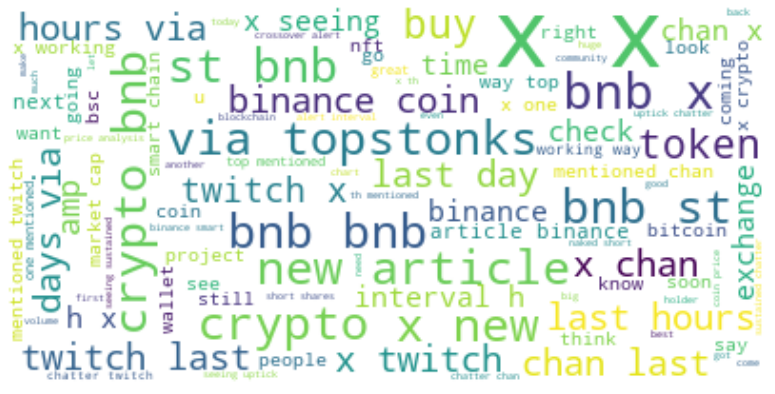

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  89744
The number of unique words:  9746
Top 40 frequent words:  ['x', 'k', 'bitcoin', 'crypto', 'buy', 'btc', 'going', 'like', 'market', 'get', 'bears', 'go', 'time', 'money', 'people', 'quot', 'next', 'new', 'see', 'back', 'bulls', 'one', 'short', 'price', 'still', 'bottom', 'bear', 'let', 'good', 'bullish', 'week', 'think', 'pump', 'big', 'know', 'lol', 'make', 'today', 'would', 'sell']


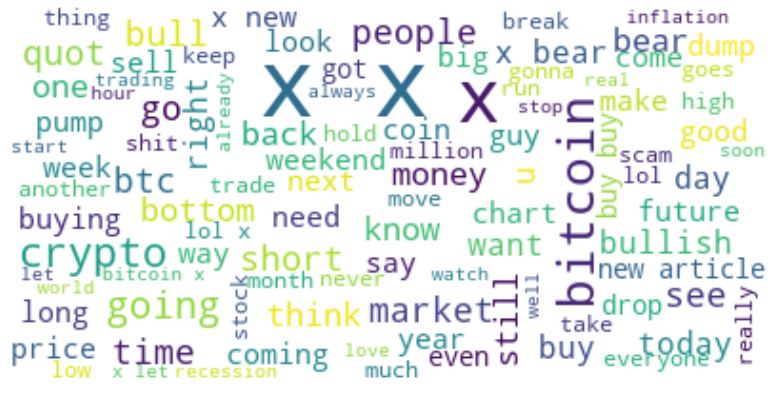

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  75986
The number of unique words:  8404
Top 40 frequent words:  ['x', 'doge', 'buy', 'elon', 'crypto', 'like', 'get', 'go', 'dogecoin', 'going', 'bitcoin', 'time', 'back', 'people', 'musk', 'let', 'one', 'money', 'new', 'buying', 'still', 'market', 'lol', 'coin', 'bears', 'good', 'know', 'see', 'k', 'day', 'next', 'would', 'price', 'sell', 'quot', 'pump', 'even', 'make', 'soon', 'think']


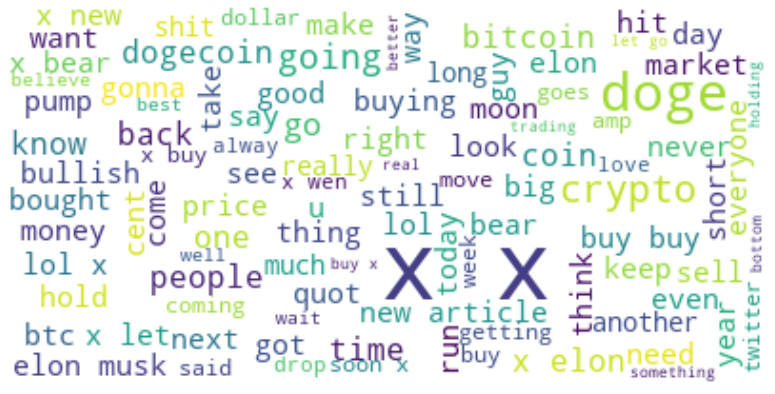

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  93454
The number of unique words:  7884
Top 40 frequent words:  ['x', 'dot', 'crypto', 'polkadot', 'new', 'chan', 'buy', 'price', 'article', 'last', 'get', 'st', 'market', 'com', 'via', 'time', 'days', 'like', 'topstonks', 'go', 'bitcoin', 'back', 'one', 'good', 'going', 'see', 'bullish', 'next', 'money', 'btc', 'bought', 'still', 'hours', 'long', 'mentioned', 'buying', 'interval', 'h', 'top', 'th']


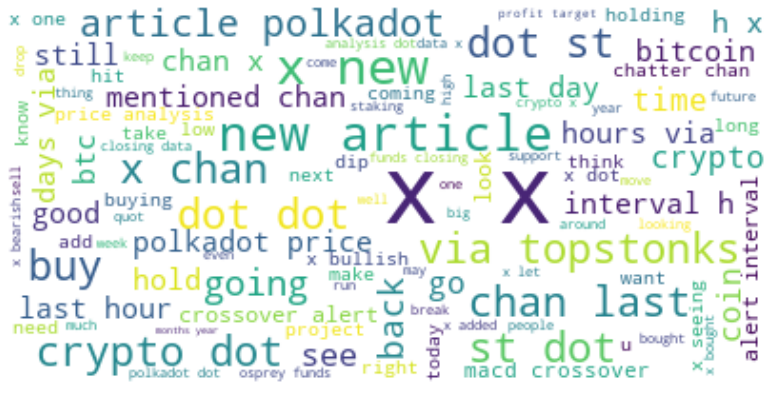

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  77017
The number of unique words:  7213
Top 40 frequent words:  ['x', 'enjin', 'buy', 'crypto', 'get', 'like', 'go', 'enj', 'metaverse', 'time', 'let', 'going', 'coin', 'nft', 'next', 'back', 'see', 'bought', 'new', 'good', 'one', 'coins', 'gaming', 'price', 'market', 'run', 'still', 'think', 'long', 'big', 'soon', 'dip', 'today', 'hold', 'holding', 'looking', 'coinbase', 'nfts', 'coming', 'got']


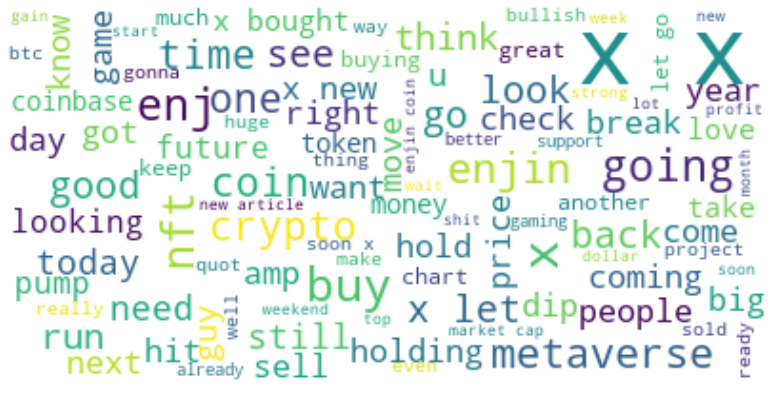

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  94480
The number of unique words:  9345
Top 40 frequent words:  ['x', 'crypto', 'buy', 'bitcoin', 'k', 'eth', 'get', 'like', 'going', 'ethereum', 'go', 'market', 'back', 'time', 'money', 'next', 'new', 'price', 'people', 'see', 'buying', 'quot', 'still', 'bottom', 'bears', 'one', 'btc', 'think', 'would', 'long', 'know', 'last', 'short', 'lol', 'week', 'bear', 'good', 'right', 'sell', 'way']


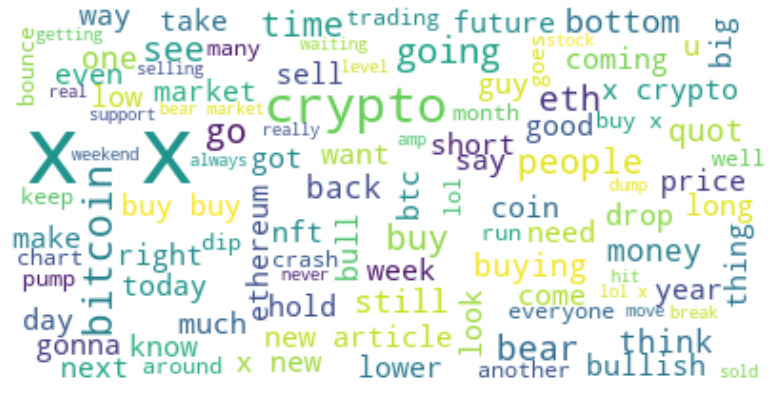

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  69807
The number of unique words:  7525
Top 40 frequent words:  ['x', 'luna', 'lunc', 'get', 'buy', 'go', 'burn', 'like', 'crypto', 'going', 'let', 'back', 'still', 'see', 'bears', 'time', 'money', 'holding', 'lol', 'good', 'one', 'new', 'market', 'hold', 'price', 'people', 'classic', 'btc', 'wluna', 'buying', 'coins', 'know', 'pump', 'kwon', 'sell', 'keep', 'would', 'make', 'zero', 'right']


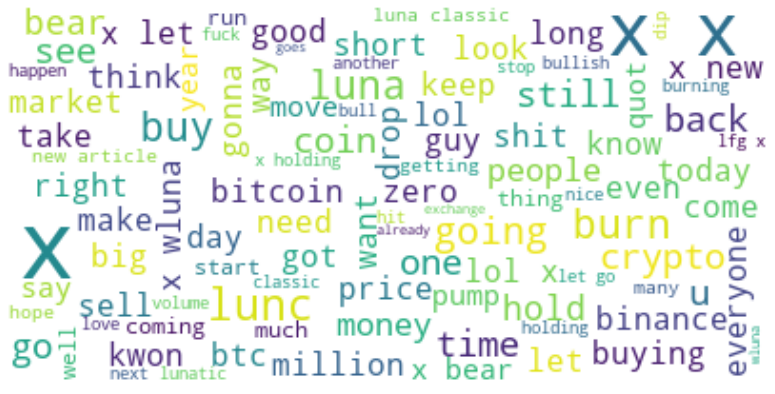

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  74753
The number of unique words:  7957
Top 40 frequent words:  ['x', 'metaverse', 'mana', 'buy', 'crypto', 'decentraland', 'go', 'like', 'going', 'new', 'get', 'time', 'back', 'price', 'let', 'see', 'market', 'one', 'next', 'long', 'good', 'bought', 'article', 'today', 'still', 'coming', 'people', 'buying', 'bitcoin', 'hold', 'soon', 'land', 'big', 'coin', 'run', 'k', 'holding', 'day', 'money', 'meta']


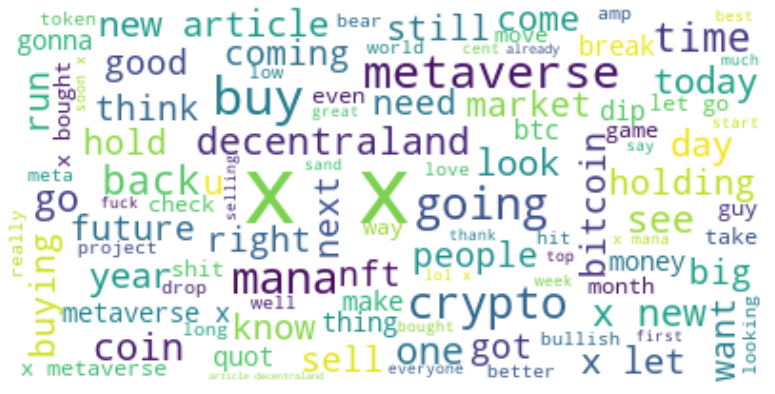

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  82978
The number of unique words:  8330
Top 40 frequent words:  ['x', 'matic', 'polygon', 'crypto', 'new', 'buy', 'article', 'get', 'like', 'go', 'going', 'see', 'price', 'market', 'time', 'back', 'one', 'next', 'good', 'buying', 'btc', 'long', 'k', 'let', 'still', 'bought', 'last', 'bullish', 'dip', 'money', 'lol', 'today', 'people', 'hold', 'coins', 'news', 'soon', 'bitcoin', 'think', 'coin']


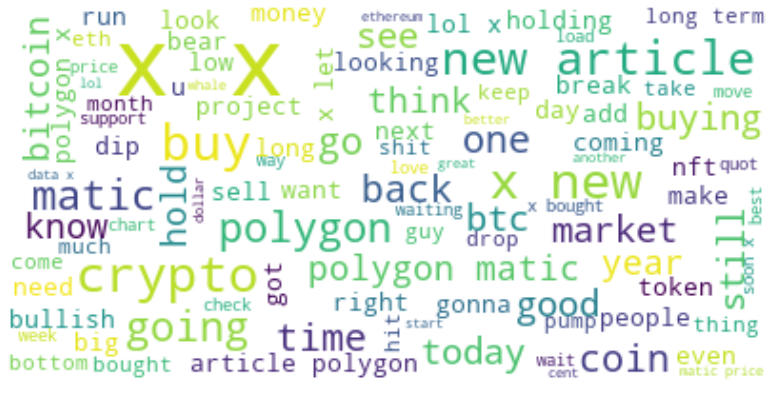

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  86321
The number of unique words:  9693
Top 40 frequent words:  ['meta', 'market', 'buy', 'like', 'stock', 'today', 'quot', 'going', 'options', 'see', 'metaverse', 'amp', 'day', 'go', 'new', 'week', 'facebook', 'time', 'get', 'money', 'next', 'company', 'back', 'one', 'x', 'trading', 'fb', 'calls', 'k', 'tomorrow', 'analysis', 'long', 'short', 'people', 'good', 'big', 'call', 'still', 'price', 'buying']


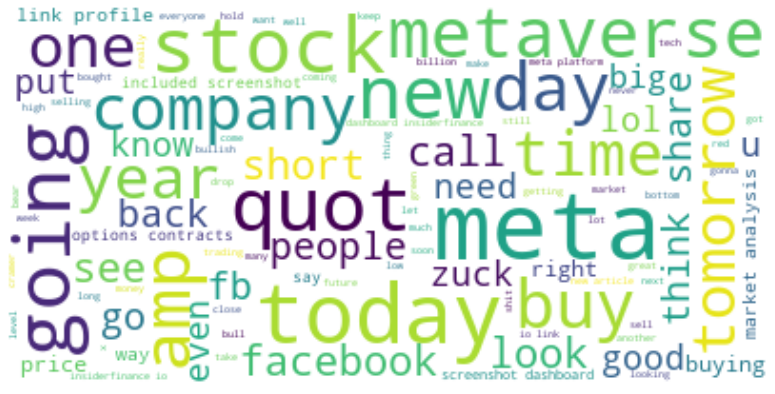

  0%|          | 0/57 [00:00<?, ?it/s]

The number of all words:  516
The number of unique words:  358
Top 40 frequent words:  ['x', 'metaverse', 'amp', 'weekly', 'update', 'best', 'opportunity', 'meta', 'go', 'potential', 'buy', 'add', 'future', 'one', 'nfts', 'today', 'price', 'etf', 'stock', 'hr', 'netlist', 'unique', 'art', 'behind', 'going', 'positions', 'bounced', 'get', 'ready', 'world', 'low', 'holds', 'break', 'added', 'buying', 'nvda', 'still', 'investing', 'well', 'like']


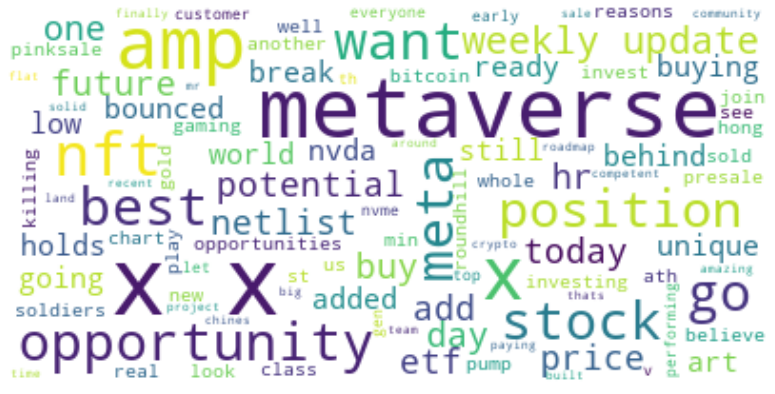

  0%|          | 0/313 [00:00<?, ?it/s]

The number of all words:  2759
The number of unique words:  980
Top 40 frequent words:  ['x', 'metaverse', 'raca', 'buy', 'top', 'coins', 'one', 'sentiment', 'crypto', 'best', 'going', 'see', 'lt', 'like', 'new', 'get', 'check', 'go', 'time', 'nice', 'luck', 'still', 'nom', 'nft', 'added', 'great', 'bought', 'let', 'future', 'de', 'dip', 'caca', 'project', 'got', 'holding', 'projects', 'early', 'people', 'next', 'exchanges']


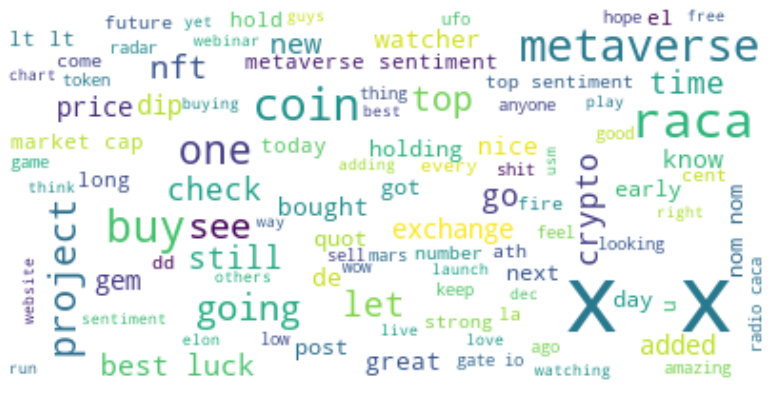

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  85041
The number of unique words:  8276
Top 40 frequent words:  ['x', 'metaverse', 'sand', 'sandbox', 'buy', 'new', 'crypto', 'like', 'get', 'go', 'going', 'article', 'next', 'back', 'time', 'see', 'market', 'one', 'price', 'good', 'soon', 'land', 'let', 'today', 'nft', 'long', 'still', 'big', 'coming', 'coins', 'play', 'know', 'news', 'meta', 'think', 'bought', 'hold', 'sell', 'check', 'coin']


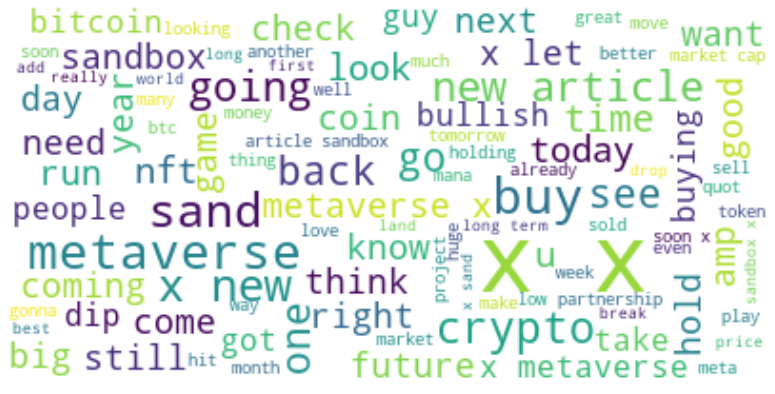

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  61546
The number of unique words:  6965
Top 40 frequent words:  ['x', 'shib', 'buy', 'go', 'shiba', 'get', 'like', 'let', 'time', 'going', 'crypto', 'back', 'hold', 'see', 'next', 'good', 'today', 'one', 'still', 'run', 'new', 'know', 'market', 'people', 'buying', 'day', 'shibarium', 'pump', 'loves', 'week', 'sell', 'price', 'holding', 'keep', 'money', 'inu', 'long', 'another', 'would', 'zero']


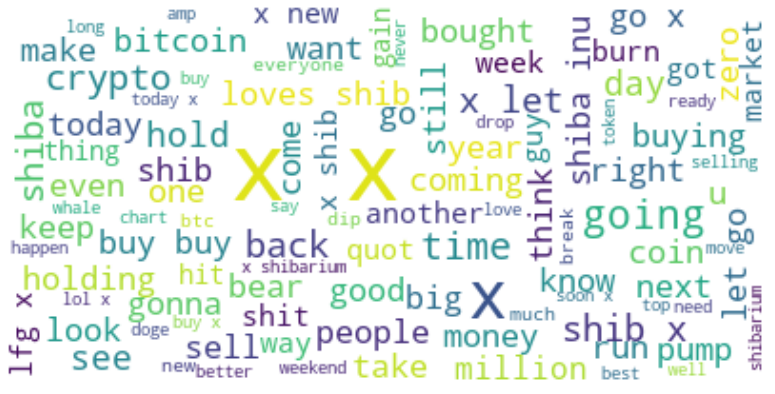

  0%|          | 0/4035 [00:00<?, ?it/s]

The number of all words:  28544
The number of unique words:  3545
Top 40 frequent words:  ['x', 'slp', 'twitch', 'crypto', 'last', 'com', 'st', 'via', 'topstonks', 'buy', 'go', 'days', 'going', 'mentioned', 'one', 'hours', 'like', 'let', 'get', 'love', 'back', 'see', 'volume', 'k', 'time', 'next', 'seeing', 'way', 'coin', 'chatter', 'good', 'still', 'axie', 'dip', 'soon', 'holding', 'hold', 'top', 'market', 'bought']


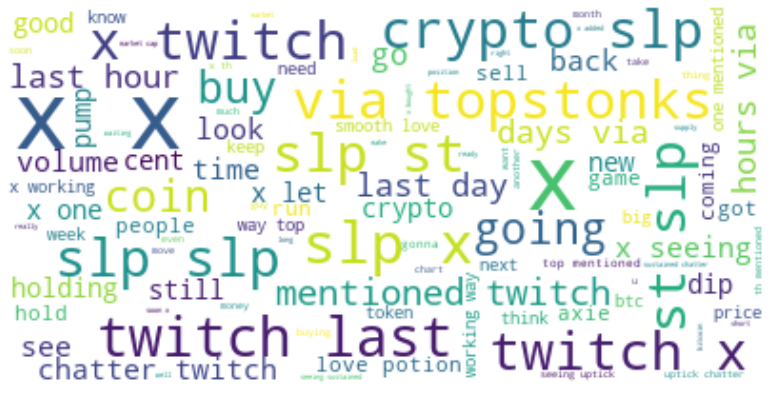

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  89311
The number of unique words:  8715
Top 40 frequent words:  ['x', 'crypto', 'solana', 'sol', 'buy', 'new', 'like', 'going', 'market', 'price', 'next', 'get', 'time', 'article', 'go', 'luna', 'back', 'see', 'bitcoin', 'one', 'still', 'good', 'buying', 'money', 'people', 'long', 'btc', 'quot', 'coins', 'soon', 'last', 'k', 'bought', 'lol', 'bears', 'think', 'even', 'know', 'coin', 'way']


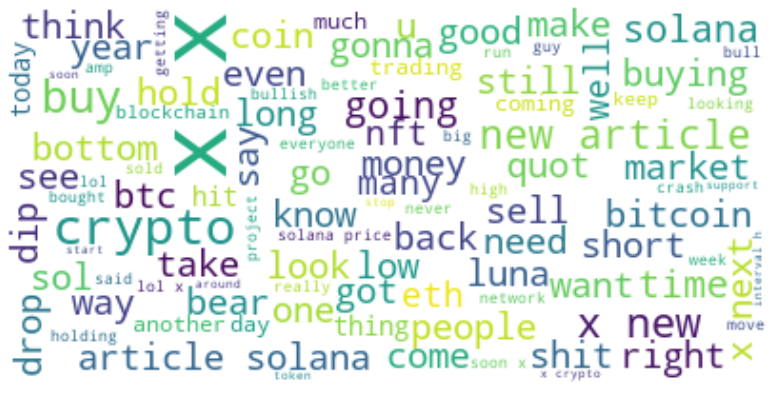

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  84377
The number of unique words:  7563
Top 40 frequent words:  ['x', 'tron', 'trx', 'crypto', 'buy', 'new', 'get', 'like', 'price', 'go', 'market', 'justin', 'article', 'let', 'use', 'see', 'sun', 'going', 'time', 'coin', 'good', 'one', 'chart', 'next', 'still', 'holding', 'usdd', 'btc', 'bitcoin', 'coins', 'big', 'back', 'trade', 'us', 'bullish', 'stop', 'know', 'people', 'average', 'well']


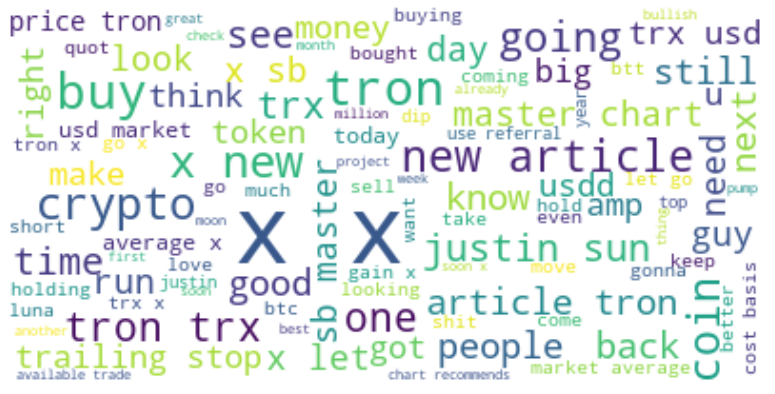

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  97778
The number of unique words:  8199
Top 40 frequent words:  ['x', 'usdt', 'crypto', 'twitch', 'mentioned', 'tether', 'last', 'com', 'hours', 'buy', 'st', 'via', 'topstonks', 'coins', 'new', 'going', 'amp', 'get', 'full', 'times', 'live', 'coin', 'like', 'data', 'reddit', 'estimated', 'historical', 'ranked', 'subreddit', 'quiverquant', 'article', 'one', 'days', 'market', 'money', 'dollar', 'go', 'trending', 'seeing', 'moon']


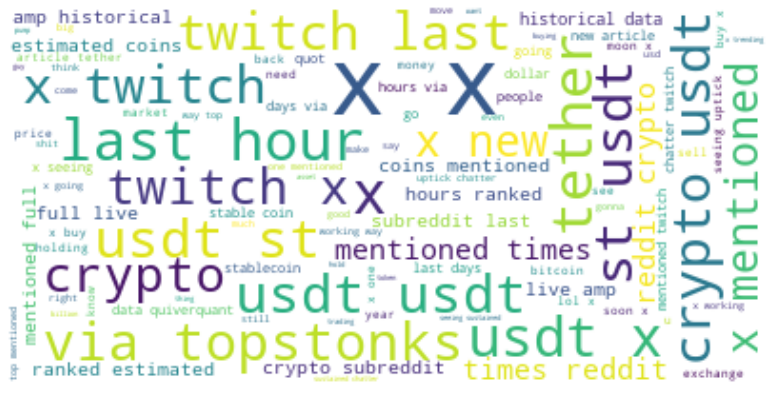

In [17]:
explore_frequent_words(messages)

# Data Preparation & Features Selection


*   Validate data - normal distribution
*   Data Distribution
*   Split training data & test data

In [18]:
StockTwits = pd.read_csv(r"Data/StockTwits.csv", sep="\t")
print(StockTwits.describe())

          Unnamed: 0          label
count  168292.000000  168292.000000
mean     4858.650560       1.394119
std      2913.804505       0.632117
min         0.000000       0.000000
25%      2316.000000       1.000000
50%      4760.000000       1.000000
75%      7390.000000       2.000000
max     10019.000000       2.000000


In [19]:
StockTwits

Unnamed: 0        date   time_ET  \
0                0  2022-06-27  12:10:57   
1                1  2022-06-27  06:17:33   
2                2  2022-06-27  06:03:23   
3                3  2022-06-27  04:39:08   
4                4  2022-06-27  01:40:07   
...            ...         ...       ...   
168287       10015  2021-05-26  09:42:10   
168288       10016  2021-05-26  06:44:34   
168289       10017  2021-05-26  01:54:07   
168290       10018  2021-05-26  01:25:33   
168291       10019  2021-05-25  23:03:46   

                                              org message  \
0       $SOL.X $LTC.X $AVAX.X play attention to $AVT.X...   
1                                           $AVAX.X ⭐⭐⭐⭐⭐   
2       $AVAX.X $VPND.X\n\nYes this actually happening...   
3       $AVAX.X NEW ARTICLE : Avalanche price analysis...   
4       $AVAX.X NEW ARTICLE : Investors Are Gearing Up...   
...                                                   ...   
168287  $USDT.X Scared me to death\nhttps://www.youtub...   
168288  $USDT.X working it&#39;s way into the top 10 m...   
168289  $USDT.X seeing sustained chatter on twitch ove...   
168290  The Digital 💵 Yuan Project | The Digital Yuan ...   
168291  $USDT.X seeing an uptick in chatter on twitch ...   

                                                 sentence  label  
0       x x x play attention x volume started insane m...      2  
1                                                       x      2  
2       x x yes actually happening sleep choose claim ...      2  
3       x new article avalanche price analysis avax us...      1  
4       x new article investors gearing gnox gnox pres...      1  
...                                                   ...    ...  
168287                                     x scared death      1  
168288  x working way top mentioned twitch last hours ...      1  
168289  x seeing sustained chatter twitch last days vi...      1  
168290  digital yuan project digital yuan cbdc episode...      2  
168291  x seeing uptick chatter twitch last hours via ...      1  

[168292 rows x 6 columns]

In [20]:
def explore_frequent_words_all(messages): 
    preprocesseds = []
    # Process for all messages
    preprocessed = [preprocess(msg) for msg in tqdm(message)]
    preprocesseds.append(preprocessed)

    all_words = [word for message in preprocessed for word in message.split()]
    print('The number of all words: ', len(all_words))

    counts = Counter(all_words)
    print('The number of unique words: ', len(counts))

    bow = sorted(counts, key=counts.get, reverse=True)
    print('Top 40 frequent words: ', bow[:40])

    text = " ".join(all_words)

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=None, max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(15,7))
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  97778
The number of unique words:  8199
Top 40 frequent words:  ['x', 'usdt', 'crypto', 'twitch', 'mentioned', 'tether', 'last', 'com', 'hours', 'buy', 'st', 'via', 'topstonks', 'coins', 'new', 'going', 'amp', 'get', 'full', 'times', 'live', 'coin', 'like', 'data', 'reddit', 'estimated', 'historical', 'ranked', 'subreddit', 'quiverquant', 'article', 'one', 'days', 'market', 'money', 'dollar', 'go', 'trending', 'seeing', 'moon']


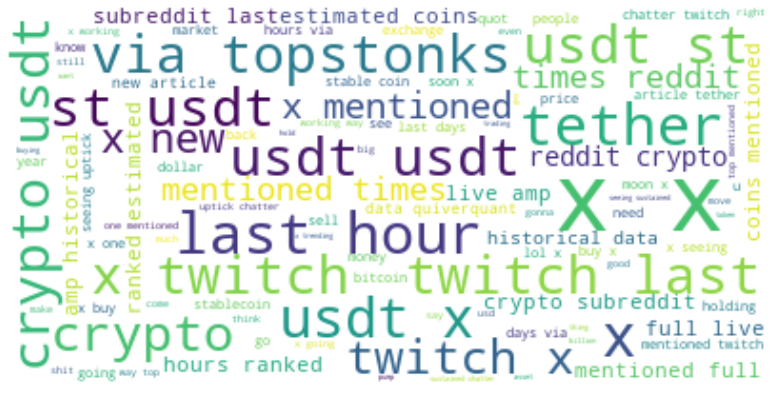

In [21]:
explore_frequent_words_all(StockTwits['sentence'])

In [22]:
len(StockTwits['sentence'])

168292

<AxesSubplot:ylabel='Density'>

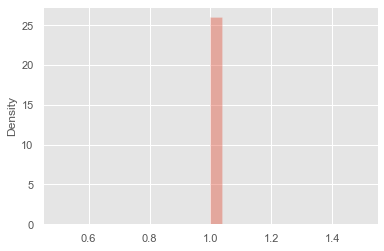

In [23]:
sns.distplot([len(x) for x in str(StockTwits['sentence'])])

The total number of data:  168292


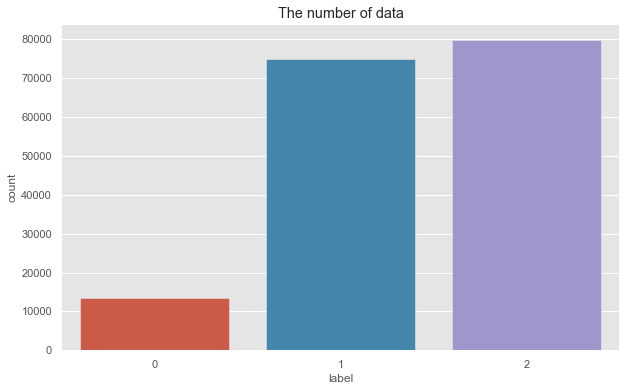

In [24]:
print("The total number of data: ", len(StockTwits['label']))
plt.figure(figsize=(10,6))
sns.countplot(x=StockTwits['label'])
plt.title('The number of data')
plt.show()

0 = negative
1 = neutral
2 = positive

More than 8% of the data are labeled as "negative". Sometimes imbalanced data are balanced using methods like resampling (oversampling, undersampling) as models tend to predict the majority class more. SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

Here, take label = 0, 1, 2 and balance the data using random down sampling method

In [25]:
# Set Random Seed

import torch
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [26]:
# Take 0, 2, 4 and update them to 0, 1, 2
train_df = StockTwits.loc[(StockTwits['label']==int(0))|(StockTwits['label']==int(1))|(StockTwits['label']==int(2))]
def update_label(x):
    if x == int(2):
        return int(2)
    elif x == int(1):
        return int(1)
    else:
        return int(0)
train_df['label'] = train_df['label'].apply(lambda x: update_label(x))

# Balancing the data
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = train_df.shape[0]

print(n_negative)
print(n_neutral)
print(n_positive)
print(N_examples)

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)

balanced = {'org message': [], 'sentence': [], 'label': []}

# Keep probability
# As the negative has the least number of data, trim neutral and positive
keep_prob_neutral = n_negative/n_neutral
keep_prob_positive = n_negative/n_positive
#keep_prob = 1

for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if str(row['sentence']).strip() == "":
        continue
    elif (row['label'] == 0) or ((row['label'] == 1) and (random.random() < keep_prob_neutral)) or ((row['label'] == 2) and (random.random() < keep_prob_positive)):
        balanced['org message'].append(row['org message'])
        balanced['sentence'].append(str(row['sentence']))
        balanced['label'].append(row['label'])

train_df = pd.DataFrame(balanced)
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = len(train_df)

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)

13529
74907
79856
168292
Negative: 0.08039003636536496
Neutral:  0.44510137142585504
Positive: 0.47450859220878
Total records:  168292


  0%|          | 0/168292 [00:00<?, ?it/s]

Negative: 0.3316662989384913
Neutral:  0.33482876124635336
Positive: 0.3335049398151553
Total records:  40791


The total number of data:  40791


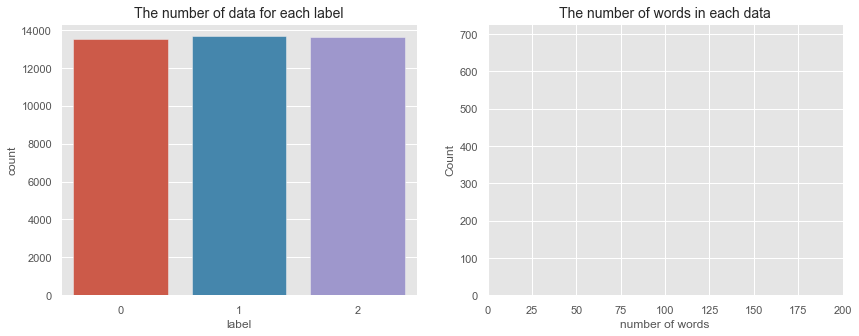

In [27]:
print("The total number of data: ", len(train_df))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)

sns.histplot([len(x) for x in str(train_df['sentence'])], ax=ax2, bins=100)
ax2.set_title('The number of words in each data', fontsize=14)
ax2.set_xlim(0,200)
ax2.set_xlabel('number of words')
plt.show()

In [28]:
train_df.to_csv(r"Data/StockTwits_Balance.csv", sep="\t")    

In [29]:
train_df

org message  \
0                                          $AVAX.X ⭐⭐⭐⭐⭐   
1      $AVAX.X we need this to go to 200 real quick n...   
2                        $AVAX.X Better late than never…   
3      $AVAX.X   \n \nHey guys! Do you want to step a...   
4      $AVAX.X Beautiful recovery. Congrats to all wh...   
...                                                  ...   
40786  $USDT.X seeing sustained chatter on twitch ove...   
40787  $USDT.X  $BTC.X  scam. Watch out.\n\nhttps://n...   
40788                                 $USDT.X total scam   
40789                                     $BTC.X $USDT.X   
40790  $USDT.X seeing an uptick in chatter on twitch ...   

                                                sentence  label  
0                                                      x      2  
1      x need go real quick represent colorado lol ch...      2  
2                                    x better late never      2  
3      x hey guys want step away centralised exchange...      2  
4      x beautiful recovery congrats stayed course pi...      2  
...                                                  ...    ...  
40786  x seeing sustained chatter twitch last days vi...      1  
40787                                     x x scam watch      0  
40788                                       x total scam      0  
40789                                                x x      0  
40790  x seeing uptick chatter twitch last hours via ...      1  

[40791 rows x 3 columns]

  0%|          | 0/10020 [00:00<?, ?it/s]

The number of all words:  97778
The number of unique words:  8199
Top 40 frequent words:  ['x', 'usdt', 'crypto', 'twitch', 'mentioned', 'tether', 'last', 'com', 'hours', 'buy', 'st', 'via', 'topstonks', 'coins', 'new', 'going', 'amp', 'get', 'full', 'times', 'live', 'coin', 'like', 'data', 'reddit', 'estimated', 'historical', 'ranked', 'subreddit', 'quiverquant', 'article', 'one', 'days', 'market', 'money', 'dollar', 'go', 'trending', 'seeing', 'moon']


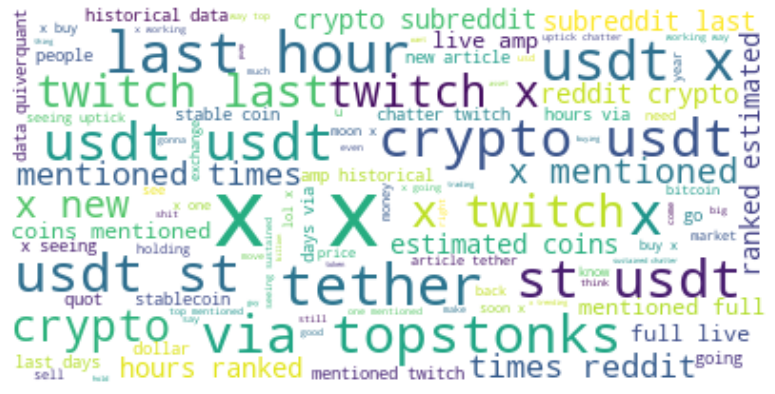

In [30]:
explore_frequent_words_all(train_df['sentence'])

In [31]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

<AxesSubplot:ylabel='Density'>

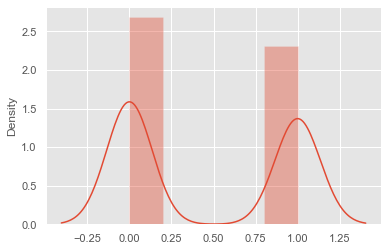

In [32]:
# Check the distribution to decide the maximum length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sns.distplot([len(tokenizer.tokenize(text)) for text in str(train_df['sentence'])])

In [33]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [34]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
inputs = tokenizer("Hello, my cat is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)
print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = bert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

inputs: 
 {'input_ids': tensor([[  101,  7592,  1010,  2026,  4937,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [35]:
# Split the data
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
test = train_df[~msk]

In [36]:
#out of memory required to run this for refresh memory
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [37]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length):
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # # Train Data in Tensor
    # train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    # train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    # train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    # train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # # Validation Data in Tensor
    # valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    # valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    # valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    # valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # # Load data into TensorDataset
    # train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    # valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    print('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_HF(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    ## Set Loss Function
    ## If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    #loss_fn = torch.nn.CrossEntropyLoss()

    ## Set Optimizer
    ## Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    ## If we use torch.optim.Adam, set with parameter groups like this:
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'padding': 'max_length',
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((len(y_valid), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        # print('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in enumerate(train_loader):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            outputs= model(**x_train_bt, labels=y_train_bt)
            #print(type(outputs))
            
            loss = outputs.loss
            
            #digits = outputs.digits
            # Calculate Loss - no longer required.
            #loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        #valid_preds_fold = np.zeros((y_valid.size(0), 3))
        y_valid_pred = np.zeros((len(y_valid), 3))
        
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                outputs = model(**x_valid_bt, labels=y_valid_bt)
                loss = outputs.loss
                logits = outputs.logits
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
            #torch.save(model.state_dict(), output_dir + out_model_name)
        else:
            early_stop += 1
            
        print('epoch: %d, train loss: %.4f, valid loss: %.4f, acc: %.4f, f1: %.4f, best_f1: %.4f, last lr: %.6f' %
              (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    print('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o', label='Training Loss')
    plt.plot(valid_losses, 'r-o', label='Validation Loss')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    ## Load the best model
    #model.load_state_dict(torch.load(output_dir + out_model_name))
    ## Set the model to Evaluation Mode
    #model.eval()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return acc, f1, valid_best, model

In [38]:
# Hyperparameters
learning_rate = 2e-5
num_epochs = 6       #adjust to around 6-9
batch_size = 64
patience = 2
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 96

# bert_hidden_size = 768
# bert_dense_size = 128

In [39]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
# Define a DataSet Class which simply return (x, y) pair instead
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

In [42]:
# Set logger
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_model_comparison_tweet', logging.DEBUG)

================     fold 1    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 2454 (409 batches x 6 epochs)


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

[2022-07-10 15:00:23,769][DEBUG] ## train batch: 0, train_loss: 0.002703
[2022-07-10 15:00:24,494][DEBUG] ## train batch: 1, train_loss: 0.002714
[2022-07-10 15:00:25,230][DEBUG] ## train batch: 2, train_loss: 0.002704
[2022-07-10 15:00:25,962][DEBUG] ## train batch: 3, train_loss: 0.002803
[2022-07-10 15:00:26,695][DEBUG] ## train batch: 4, train_loss: 0.002730
[2022-07-10 15:00:27,440][DEBUG] ## train batch: 5, train_loss: 0.002663
[2022-07-10 15:00:28,206][DEBUG] ## train batch: 6, train_loss: 0.002687
[2022-07-10 15:00:28,941][DEBUG] ## train batch: 7, train_loss: 0.002749
[2022-07-10 15:00:29,683][DEBUG] ## train batch: 8, train_loss: 0.002664
[2022-07-10 15:00:30,418][DEBUG] ## train batch: 9, train_loss: 0.002713
[2022-07-10 15:00:31,152][DEBUG] ## train batch: 10, train_loss: 0.002766
[2022-07-10 15:00:31,885][DEBUG] ## train batch: 11, train_loss: 0.002736
[2022-07-10 15:00:32,622][DEBUG] ## train batch: 12, train_loss: 0.002601
[2022-07-10 15:00:33,369][DEBUG] ## train batch:

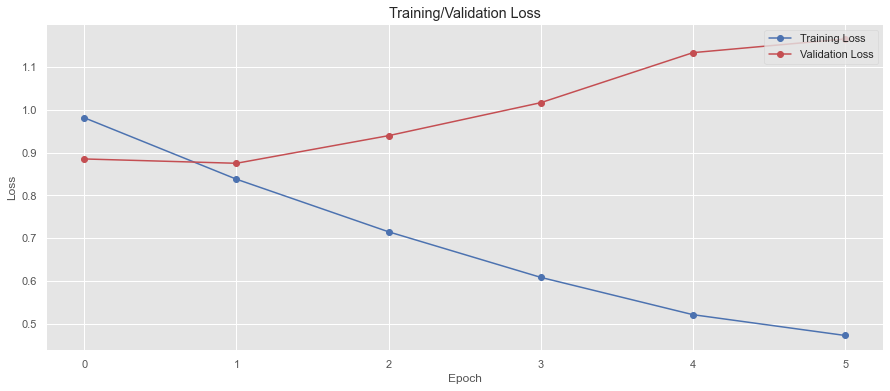

[2022-07-10 15:37:04,023][INFO] ## epoch: best, acc: 0.58524640, f1: 0.58223633, best_f1: 0.58223633



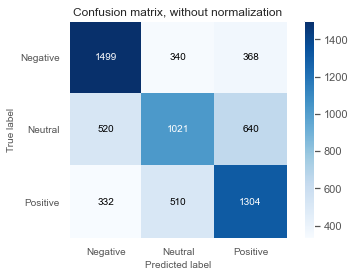

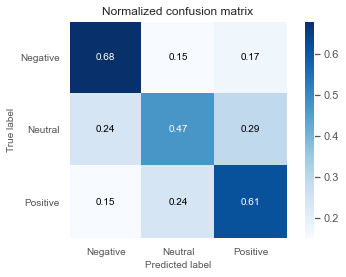

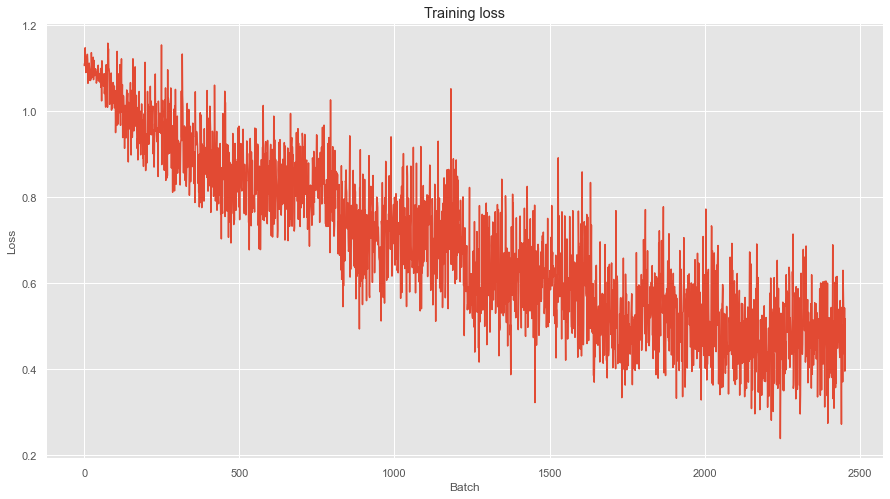

#################### FINAL RESULT ####################
Average Accuracy: 0.58524640, Average F1: 0.58223633


In [43]:
# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

acc_list, f1_list = [], []

for n_fold, (train_indices, valid_indices) in enumerate(kfold.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    acc, f1, valid_best, _ = train_transformer(bert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 0:
        break

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 3066 (511 batches x 6 epochs)


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

[2022-07-10 15:37:10,828][DEBUG] ## train batch: 0, train_loss: 0.002325
[2022-07-10 15:37:11,745][DEBUG] ## train batch: 1, train_loss: 0.002407
[2022-07-10 15:37:12,666][DEBUG] ## train batch: 2, train_loss: 0.002235
[2022-07-10 15:37:13,582][DEBUG] ## train batch: 3, train_loss: 0.002313
[2022-07-10 15:37:14,464][DEBUG] ## train batch: 4, train_loss: 0.002302
[2022-07-10 15:37:15,285][DEBUG] ## train batch: 5, train_loss: 0.002555
[2022-07-10 15:37:16,113][DEBUG] ## train batch: 6, train_loss: 0.002408
[2022-07-10 15:37:16,935][DEBUG] ## train batch: 7, train_loss: 0.002461
[2022-07-10 15:37:17,733][DEBUG] ## train batch: 8, train_loss: 0.002411
[2022-07-10 15:37:18,523][DEBUG] ## train batch: 9, train_loss: 0.002289
[2022-07-10 15:37:19,330][DEBUG] ## train batch: 10, train_loss: 0.002302
[2022-07-10 15:37:20,179][DEBUG] ## train batch: 11, train_loss: 0.002148
[2022-07-10 15:37:20,979][DEBUG] ## train batch: 12, train_loss: 0.002416
[2022-07-10 15:37:21,789][DEBUG] ## train batch:

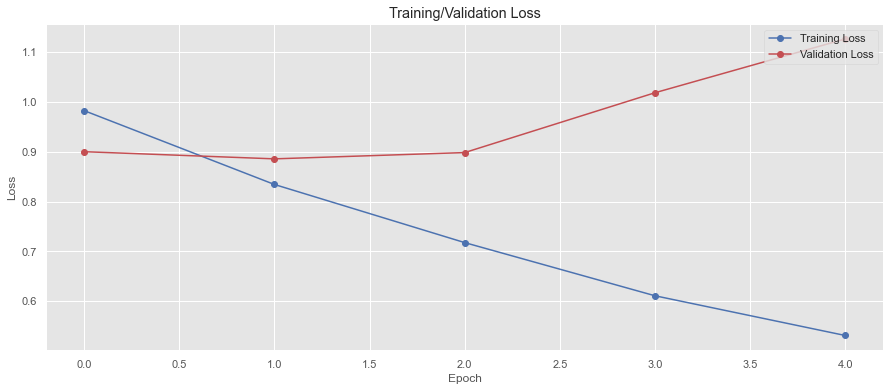

[2022-07-10 16:18:46,807][INFO] ## epoch: best, acc: 0.58074840, f1: 0.57659707, best_f1: 0.57659707



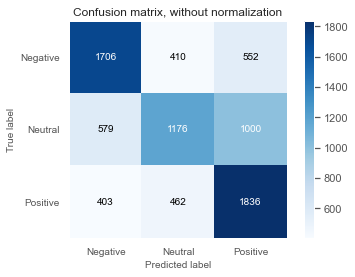

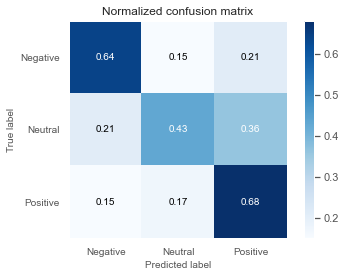

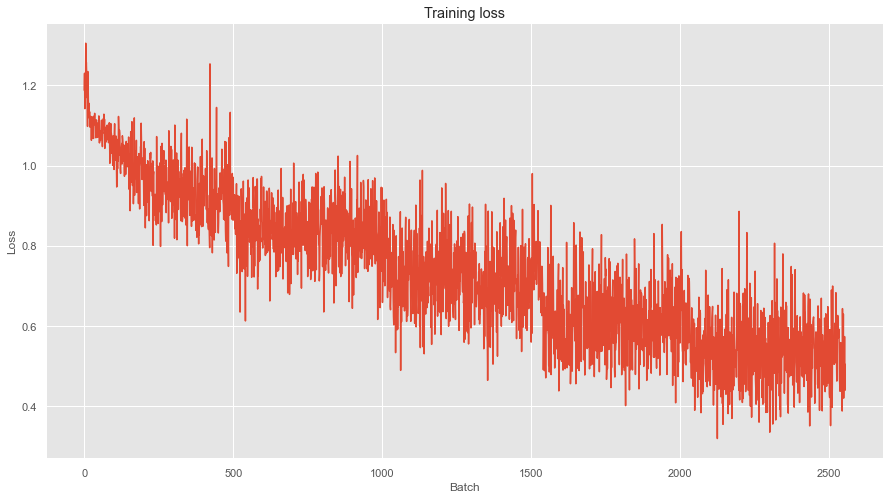

Accuracy: 0.58074840, f1: 0.57659707



NameError: name 'output_dir' is not defined

In [44]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

acc, f1, valid_best, model_trained = \
        train_transformer(bert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

torch.save(model_trained.state_dict(), output_dir + 'fintweet_bert.dict')

In [47]:
output_dir = "Models/BERT/"
torch.save(model_trained.state_dict(), output_dir + 'fintweet_bert.dict')